In [3]:
from tqdm import tqdm
import pandas as pd
import os

In [4]:

wd = "//wsl.localhost/ubuntu/home/gw240/projects/alibaba/clusterdata/cluster-trace-microservices-v2022/data/CallGraph/"
# Path to the directory containing your files
directory_path = wd
files = os.listdir(directory_path)
filename = files[0]
file_path = os.path.join(directory_path, filename)
# Load the DataFrame
df = pd.read_csv(file_path, compression='gzip', header=0, sep=',', quotechar='"',on_bad_lines="warn");

Skipping line 3685: expected 11 fields, saw 12
Skipping line 4483: expected 11 fields, saw 12
Skipping line 9698: expected 11 fields, saw 12
Skipping line 9703: expected 11 fields, saw 12
Skipping line 16094: expected 11 fields, saw 12
Skipping line 19027: expected 11 fields, saw 12
Skipping line 19479: expected 11 fields, saw 12
Skipping line 19968: expected 11 fields, saw 12
Skipping line 21909: expected 11 fields, saw 12
Skipping line 21911: expected 11 fields, saw 12
Skipping line 32127: expected 11 fields, saw 12
Skipping line 32128: expected 11 fields, saw 12
Skipping line 32849: expected 11 fields, saw 12
Skipping line 33131: expected 11 fields, saw 12
Skipping line 33132: expected 11 fields, saw 12
Skipping line 33136: expected 11 fields, saw 12
Skipping line 33137: expected 11 fields, saw 12
Skipping line 34262: expected 11 fields, saw 12
Skipping line 34263: expected 11 fields, saw 12
Skipping line 34265: expected 11 fields, saw 12
Skipping line 34267: expected 11 fields, saw

In [5]:
MSCallGraph = df
service_traceid_count = MSCallGraph.groupby('service')['traceid'].nunique().reset_index(name='unique_traceid_count')
service_traceid_count

,service,unique_traceid_count
0,S_100004553,1
1,S_10001104,1
2,S_100014200,1
3,S_100020042,1
4,S_100022081,1
...,...,...
100181,S_99947712,1
100182,S_99960338,1
100183,S_99962736,1
100184,S_99993205,1


In [6]:
import matplotlib.pyplot as plt

# Assuming MSCallGraph is your DataFrame and is already loaded with data

# Create a unique identifier for each call pattern
MSCallGraph['call_pattern'] = list(zip(MSCallGraph['um'], MSCallGraph['dm']))

# Group by service and traceid and calculate the number of unique call patterns
service_traceid_call_patterns = MSCallGraph.groupby(['service', 'traceid'])['call_pattern'].nunique()

# Reset index so we can work with the data as a DataFrame
df_call_patterns = service_traceid_call_patterns.reset_index(name='unique_call_patterns')

In [5]:
# Statistical summary per service
summary_statistics = df_call_patterns.groupby('service')['unique_call_patterns'].describe()

KeyboardInterrupt: 

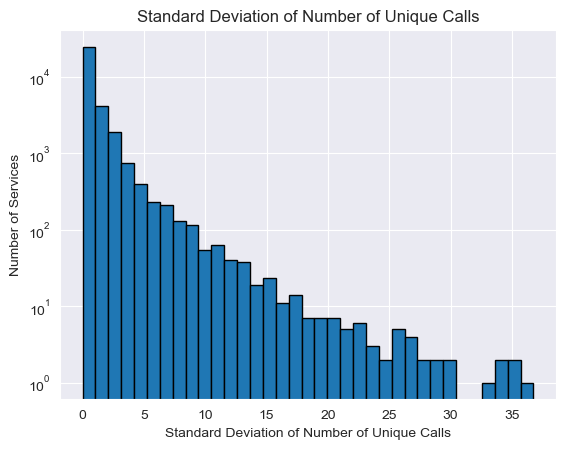

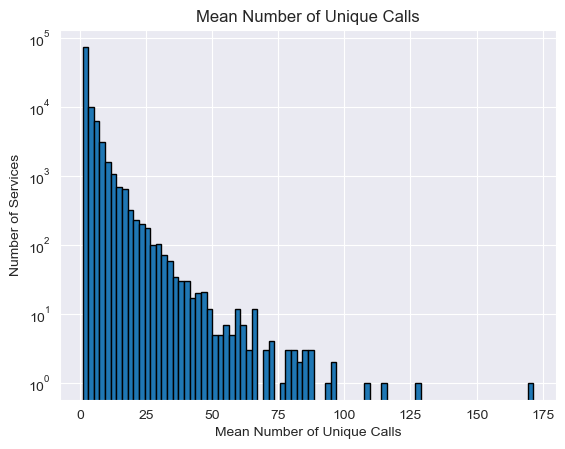

In [6]:
plt.figure()
plt.hist(summary_statistics["std"],bins=35,edgecolor='black')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel("Standard Deviation of Number of Unique Calls")
plt.ylabel("Number of Services")
plt.title("Standard Deviation of Number of Unique Calls")
plt.show()

plt.figure()
plt.hist(summary_statistics["mean"],bins=80,edgecolor='black')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel("Mean Number of Unique Calls")
plt.ylabel("Number of Services")
plt.title("Mean Number of Unique Calls")
plt.show()

In [7]:
# Group by service and traceid, then create a list of call_pattern tuples for each group
grouped = MSCallGraph.groupby(['service', 'traceid'])['call_pattern'].apply(list).reset_index()

# Now group by service only, to create a list of lists of call patterns for each service
service_call_patterns = grouped.groupby('service')['call_pattern'].apply(list).reset_index(name='pattern_list')


In [8]:
service_call_patterns.items()

<generator object DataFrame.items at 0x000001F74EC18A50>

In [9]:
for service, patterns in tqdm(service_call_patterns.items(),total=len(service_traceid_call_patterns)):
    if len(patterns)>10:
        break

  0%|          | 0/2654607 [00:00<?, ?it/s]


In [10]:
patterns

0         S_100004553
1          S_10001104
2         S_100014200
3         S_100020042
4         S_100022081
             ...     
100181     S_99947712
100182     S_99960338
100183     S_99962736
100184     S_99993205
100185     S_99994941
Name: service, Length: 100186, dtype: object

In [7]:
from itertools import combinations
import multiprocessing
import numpy as np
from tqdm import tqdm
import pandas as pd

# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0

def mean_jaccard_similarity(patterns):
    # Generator expression - calculates one similarity at a time
    similarities = (jaccard_similarity(set(a), set(b)) for a, b in combinations(patterns, 2))
    total, count = 0, 0
    for similarity in similarities:
        total += similarity
        count += 1
    return total / count if count else 0

# Assuming 'service_call_patterns' is the name of your DataFrame and it contains 'service' and 'pattern_list' columns

# Dictionary to store the results
service_similarities = {}

n_large=0
# Then, for each service, call the mean_jaccard_similarity function
for index, row in tqdm(service_call_patterns.iterrows(), total=service_call_patterns.shape[0]):
    service = row['service']
    patterns = row['pattern_list']
    if len(patterns) != 1:
        mean_similarity = mean_jaccard_similarity([set(pattern) for pattern in patterns])  # Convert tuples to sets
        # Store the result
        service_similarities[service] = mean_similarity
    elif len(patterns) != 1:
        n_large+=1
        break
        # pairs = list(combinations(patterns,2))
        # pool = multiprocessing.Pool(processes=4)
        # results = pool.map(jaccard_similarity,pairs)
        # pool.close()
        # pool.join()
        # service_similarities[service] = results

# Convert results to DataFrame for better visualization and analysis
df_results = pd.DataFrame.from_dict(service_similarities, orient='index', columns=['mean_jaccard_similarity'])

# Display the results
print(df_results)

 21%|██        | 20687/100186 [47:04<3:00:54,  7.32it/s]


KeyboardInterrupt: 

In [13]:
def mean_jaccard_similarity(patterns):
    # Generator expression - calculates one similarity at a time
    similarities = (jaccard_similarity(set(a), set(b)) for a, b in combinations(patterns, 2))
    total, count = 0, 0
    for similarity in tqdm(similarities):
        total += similarity
        count += 1
    return total / count if count else 0

mean_jaccard_similarity(patterns)

13325703it [00:24, 553946.62it/s]


0.8961166160900104

In [9]:
from itertools import combinations
import numpy as np
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed

# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0

def calculate_similarity_for_service(patterns):
    return mean_jaccard_similarity([set(pattern) for pattern in patterns])

def mean_jaccard_similarity(patterns):
    # Generator expression - calculates one similarity at a time
    similarities = (jaccard_similarity(set(a), set(b)) for a, b in combinations(patterns, 2))
    total, count = 0, 0
    for similarity in similarities:
        total += similarity
        count += 1
    return total / count if count else 0

# Dictionary to store the results
service_similarities = {}

# Set up the process pool for parallel execution
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = {}
    # Submit tasks for parallel execution
    for index, row in tqdm(service_call_patterns.iterrows(), total=len(service_call_patterns)):
        service = row['service']
        patterns = row['pattern_list']
        if len(patterns) > 20000:  # Only parallelize if more than 5000 patterns
            print(len(patterns))
            futures[executor.submit(calculate_similarity_for_service, patterns)] = service
        elif len(patterns) != 1:
            service_similarities[service] = (len(patterns), calculate_similarity_for_service(patterns))
        else:
            service_similarities[service] = (1, 1)

    # Retrieve results as they are completed
    for future in as_completed(futures):
        service = futures[future]
        try:
            similarity = future.result()
            service_similarities[service] = similarity
        except Exception as e:
            print(f"Service {service} generated an exception: {e}")

# Convert results to DataFrame for better visualization and analysis
df_results = pd.DataFrame.from_dict(service_similarities, orient='index', columns=['mean_jaccard_similarity'])

# Display the results
print(df_results)

  5%|▍         | 4712/100186 [01:40<05:56, 267.70it/s] 

26499


  7%|▋         | 7221/100186 [02:01<26:08, 59.26it/s]  

27101


BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [ ]:
import calculate_similarity
df_results = calculate_similarity.process_similarities(service_call_patterns)

In [17]:
import importlib
importlib.reload(calculate_similarity)

<module 'calculate_similarity' from 'D:\\Documents\\PhD\\Code\\alibaba-explore\\calculate_similarity.py'>

In [ ]:
import calculate_similarity
# Dictionary to store the results
service_similarities = {}

# Loop through each service and calculate the mean Jaccard similarity
for index, row in tqdm(service_call_patterns.iterrows(), total = len(service_call_patterns)):
    service = row['service']
    patterns = row['pattern_list']
    if len(patterns) > 100:
        service_similarities[service] = calculate_similarity.mean_jaccard_similarity_parallel(patterns)

# Convert results to DataFrame for better visualization and analysis
df_results = pd.DataFrame.from_dict(service_similarities, orient='index', columns=['mean_jaccard_similarity'])

  0%|          | 0/100186 [00:00<?, ?it/s]

(array([67348.,   476.,   937.,  1311.,  1851.,  2913.,  3434.,  2525.,
         2802., 16589.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

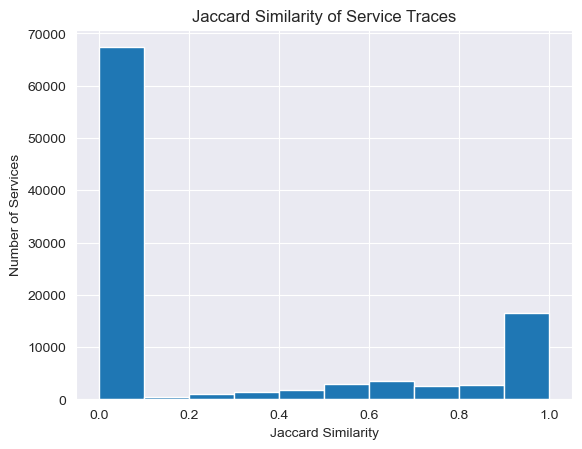

In [8]:
plt.figure()
plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of Services")
plt.title("Jaccard Similarity of Service Traces")
plt.hist(df_results,bins=10)

In [0]:
# Adjustments as per user's feedback:
# 1. Make the lines bolder.
# 2. Use less bold colors from the palette.
# 3. Adjust the timeseries data to make them less overlapping.
time = np.linspace(0, 59, 60) 
# Adjust the line width for bolder lines
line_width = 10

# Using lighter shades of the given colors for a less bold appearance
lighter_colors = [
    "red", # Lighter shade of dark blue
    "green", # Lighter shade of teal
    "blue", # Lighter shade of burnt orange
    "magenta", # Lighter shade of yellow
]

# Adjust the timeseries data to make them less overlapping
# By reducing the amplitude and slightly shifting the phases of the sine waves
cpu_usage_microservice_1 = np.abs(np.sin(0.1 * time) * 0.8 + np.random.normal(0, 0.05, len(time)))
cpu_usage_microservice_2 = np.abs(np.sin(0.1 * time + 1) * 0.8 + np.random.normal(0, 0.05, len(time))) + 0.2
cpu_usage_microservice_3 = np.abs(np.sin(0.1 * time + 2) * 0.8 + np.random.normal(0, 0.05, len(time))) + 0.4
cpu_usage_microservice_4 = np.abs(np.sin(0.1 * time + 3) * 0.8 + np.random.normal(0, 0.05, len(time))) + 0.6

plt.figure(figsize=(10, 6))

plt.plot(time, cpu_usage_microservice_1, label='Microservice 1', color=lighter_colors[0], linewidth=line_width)
plt.plot(time, cpu_usage_microservice_2, label='Microservice 2', color=lighter_colors[1], linewidth=line_width)
plt.plot(time, cpu_usage_microservice_3, label='Microservice 3', color=lighter_colors[2], linewidth=line_width)
plt.plot(time, cpu_usage_microservice_4, label='Microservice 4', color=lighter_colors[3], linewidth=line_width)

# Remove the legend, axis labels, and title
plt.axis('off')

# Make background transparent
plt.gca().set_facecolor('none')
plt.gca().figure.set_facecolor('none')

# Save the figure with a transparent background

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the adjacency matrix for a 4-node network
# Example: 4-node linear chain
A = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 0]
])

# Compute the eigenvalues
eigenvalues = np.linalg.eigvals(A)

# Plot the eigenvalues
plt.stem(eigenvalues)
plt.title('Eigenspectrum of the Network')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()


In [24]:
x1 = set(((1,2),(4,3),(4,5)))
x2 = set(((3,4),(1,2),(4,5)))
jaccard_similarity(x1,x2)

0.5

In [10]:
service_call_patterns.loc["S_100004553"]

KeyError: 'S_100004553'

In [14]:
x = service_call_patterns.loc[service_call_patterns["service"] == "S_100204880"]

In [18]:
z = list(x["pattern_list"])

In [47]:
def calculate_dissimilarity(patterns):
    unique_patterns = set(patterns)
    dissimilarity = len(unique_patterns) / len(patterns) if patterns else 0
    return dissimilarity if len(patterns) > 1 else 0

In [22]:
all_spans = [span for sublist in z for span in sublist]

In [ ]:
all_spans = [tuple(sorted(sublist)) for sublist in z]

In [36]:
for sublist in z[0]:
    h = tuple(sorted(sublist))

[('UNKNOWN', 'MS_41938'), ('MS_41938', 'MS_34785')]

In [37]:
normalized_patterns = [tuple(sorted(sublist, key=lambda x: (x[0], x[1]))) for sublist in z[0]]

In [41]:
import math
# Function to calculate entropy
def calculate_entropy(patterns):
    # Count the frequency of each unique pattern
    pattern_counts = {}
    for pattern in patterns:
        if pattern in pattern_counts:
            pattern_counts[pattern] += 1
        else:
            pattern_counts[pattern] = 1

    # Calculate probabilities
    total_patterns = len(patterns)
    probabilities = [count / total_patterns for count in pattern_counts.values()]

    # Calculate entropy
    entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    return entropy

In [11]:
service_call_patterns['normalized_patterns'] = service_call_patterns['pattern_list'].apply(lambda x: tuple(sorted(tuple(sub) for sub in x)))

In [42]:
service_call_patterns['entropy'] = service_call_patterns['normalized_patterns'].apply(calculate_entropy)

In [53]:
service_call_patterns['dissimilarity'] = service_call_patterns['normalized_patterns'].apply(calculate_dissimilarity)

In [ ]:
service_call_patterns['pattern_list'].iloc(0)

In [20]:
service_call_patterns.loc["S_100004553"]

KeyError: 'S_100004553'

In [21]:
x = service_call_patterns.loc[service_call_patterns["service"] == "S_100204880"]

In [33]:
p_list = x["pattern_list"]

In [34]:
n_list = x["normalized_patterns"]

In [37]:
len(p_list.iloc[0])

91

In [38]:
len(n_list.iloc[0])

91

In [39]:
type(n_list.iloc[0])

tuple

In [40]:
type(p_list.iloc[0])

list

In [44]:
z = set(n_list.iloc[0])

In [45]:
len(z)

8

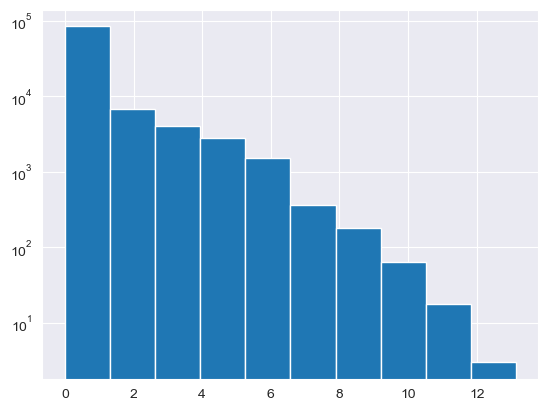

In [51]:
plt.hist(service_call_patterns["entropy"])
plt.yscale('log')

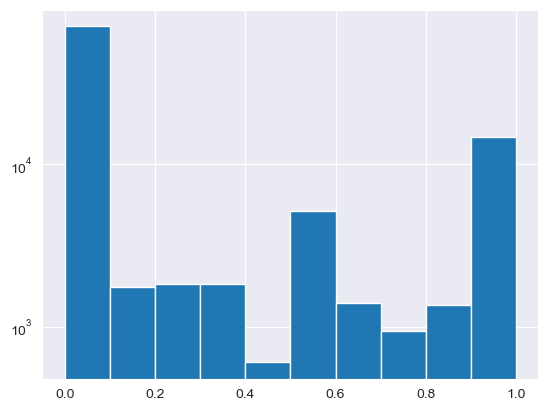

In [54]:
plt.hist(service_call_patterns["dissimilarity"])
plt.yscale('log')

In [55]:
pip install datasketch

   ---------------------------------------- 0.0/88.3 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/88.3 kB ? eta -:--:--
   ---------------------------------------- 88.3/88.3 kB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [57]:
from datasketch import MinHash, MinHashLSH
import pandas as pd

df = service_call_patterns
# Assume df is your DataFrame and 'pattern_list' contains sets of tuples
df['pattern_set'] = df['pattern_list'].apply(lambda x: set(tuple(sub) for sub in x))

# Number of permutations and hash functions
num_perm = 128

# Create MinHash objects
df['minhash'] = df['pattern_set'].apply(lambda x: MinHash(num_perm=num_perm))
for idx, row in tqdm(df.iterrows()):
    for d in row['pattern_set']:
        row['minhash'].update("".join(str(e) for e in d).encode('utf-8'))

# Initialize LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)
for idx, row in tqdm(df.iterrows()):
    lsh.insert(str(idx), row['minhash'])

# Query to find similar items
mean_similarities = []
for idx, row in tqdm(df.iterrows()):
    result = lsh.query(row['minhash'])
    all_similarities = []
    for r in result:
        if r != str(idx):
            sim = row['minhash'].jaccard(df.at[int(r), 'minhash'])
            all_similarities.append(sim)
    mean_similarity = sum(all_similarities) / len(all_similarities) if all_similarities else 0
    mean_similarities.append(mean_similarity)

df['mean_jaccard_similarity'] = mean_similarities

print(df[['service', 'mean_jaccard_similarity']])


100186it [00:25, 3929.35it/s]
100186it [00:11, 8783.51it/s]
100186it [35:49, 46.61it/s] 

            service  mean_jaccard_similarity
0       S_100004553                 0.999717
1        S_10001104                 1.000000
2       S_100014200                 0.999717
3       S_100020042                 0.999704
4       S_100022081                 0.999717
...             ...                      ...
100181   S_99947712                 1.000000
100182   S_99960338                 1.000000
100183   S_99962736                 1.000000
100184   S_99993205                 0.999704
100185   S_99994941                 0.999717

[100186 rows x 2 columns]


(array([29896.,    83.,   362.,   641.,   763.,  1345.,  1357.,  1863.,
         3944., 59932.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

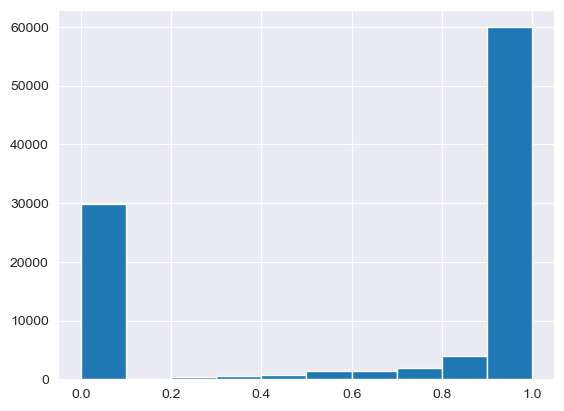

In [58]:
plt.hist(df['mean_jaccard_similarity'])

In [60]:
patterns = [[("ms1","ms2"),("ms2","ms3")],[("ms1","ms2"),("ms2","ms4")],[("ms1","ms2"),("ms2","ms4")]]
normalized_patterns = [tuple(sorted(tuple(sub))) for sub in patterns]
calculate_dissimilarity(normalized_patterns)
calculate_entropy(normalized_patterns)

In [66]:
patterns = [[("ms1","ms2"),("ms2","ms4")],[("ms1","ms2"),("ms2","ms4")],[("ms1","ms2"),("ms2","ms4")]]
normalized_patterns = [tuple(sorted(tuple(sub))) for sub in patterns]
print(calculate_dissimilarity(normalized_patterns))
print(calculate_entropy(normalized_patterns))

0.3333333333333333
-0.0


In [68]:
# Read the entire line as a single column
df = pd.read_csv(file_path, compression='gzip', header=0, delimiter='|')
df['fields'] = df.iloc[:, 0].str.split(',').apply(len)
problematic = df[df['fields'] != 11]  # Assuming 11 is the expected number of fields
print(problematic.head())


TypeError: object of type 'float' has no len()

In [90]:
z = df.iloc[131666]
len(z.str.split(',').iloc[0])
z.str.split(',').iloc[0]
z

CallGraph_369.csv    66467713,T_24804115012,S_21166341,0.1.1.1,0.1....
Name: 131666, dtype: object

In [83]:
z = df.iloc[72191]
len(z.str.split(',').iloc[0])
z.str.split(',').iloc[0]

['66515643',
 'T_22512357008',
 'S_75752507',
 '0.15.1.335015865',
 'mq',
 'MS_51864',
 'MS_51864_POD_2',
 '75fYTQJBmf',
 'MS_5312',
 'MS_5312_POD_1',
 '0.0']

In [88]:
z = df.iloc[3683]
len(z.str.split(',').iloc[0])
z

CallGraph_369.csv    66598144,T_22241341708,S_21166341,0.1.1,0.1.2,...
Name: 3683, dtype: object

In [93]:
import tarfile
import pandas as pd
from io import StringIO

def preprocess_line(line):
    fields = line.strip().split(',')
    if len(fields) > 11:  # Assuming there should be 11 fields
        fields[3] = '.'.join(fields[3:3 + (len(fields) - 11) + 1])
        del fields[4:4 + (len(fields) - 11)]
    return ','.join(fields)

def read_and_preprocess(tar_path):
    with tarfile.open(tar_path, 'r:gz') as tar:
        # Assuming there is only one file and it is a CSV
        for member in tar.getmembers():
            if member.isfile() and member.name.endswith('.csv'):
                # Extract file content
                f = tar.extractfile(member)
                if f:
                    # Read and preprocess the data
                    content = StringIO()
                    for line in f:
                        processed_line = preprocess_line(line.decode('utf-8'))
                        content.write(processed_line + '\n')
                    
                    # Reset the pointer of StringIO object to the beginning
                    content.seek(0)
                    
                    # Load the data into a DataFrame
                    df = pd.read_csv(content)
                    return df

# Specify the path to your .tar.gz file
tar_path = file_path
df = read_and_preprocess(tar_path)
print(df.head())


   timestamp        traceid     service rpc_id rpctype        um  \
0   66445110  T_23421372583  S_95523114    0.1    http   UNKNOWN   
1   66500067  T_24169529877  S_92514351  0.4.9      mc  MS_60464   
2   66500059  T_24169529877  S_92514351    0.1      mc  MS_25557   
3   66500064  T_24169529877  S_92514351  0.4.1      mc  MS_60464   
4   66500066  T_24169529877  S_92514351  0.4.6      mc  MS_60464   

       uminstanceid   interface        dm      dminstanceid   rt  
0       UNAVAILABLE  cNLNswzipm  MS_50265  MS_50265_POD_312  0.0  
1   MS_60464_POD_88  fyl9R8NKIr  MS_46825  MS_46825_POD_400  0.0  
2  MS_25557_POD_532  9QSOuuDpIx   MS_9076     MS_9076_POD_5  1.0  
3   MS_60464_POD_88  44k5XkoOxP  MS_46825  MS_46825_POD_556  0.0  
4   MS_60464_POD_88  fyl9R8NKIr  MS_46825  MS_46825_POD_264  0.0  


In [94]:
df.iloc[131666]

timestamp                  66467713
traceid               T_24804115012
service                  S_21166341
rpc_id              0.1.1.1.0.1.1.2
rpctype                         rpc
um                          UNKNOWN
uminstanceid    UNKNOWN_POD_6387478
interface                7zAD1u2Ce4
dm                          MS_7824
dminstanceid          MS_7824_POD_5
rt                              0.0
Name: 131666, dtype: object